In [1]:
from pygooglenews import GoogleNews
import pandas as pd
from datetime import datetime

In [2]:
FROM = "2023-01-01"
TO = "2023-12-31"
TOPIC = "BUSINESS"

In [3]:
ftse_top_20 = [
    "AZN",   # AstraZeneca
    "HSBA",  # HSBC Holdings
    "SHEL",  # Shell
    "ULVR",  # Unilever
    "RIO",   # Rio Tinto
    "REL",   # RELX
    "BP",    # BP
    "BATS",  # British American Tobacco
    "LSEG",  # London Stock Exchange Group
    "GSK",   # GlaxoSmithKline
    "DGE",   # Diageo
    "GLEN",  # Glencore
    "NG",    # National Grid
    "RR",    # Rolls-Royce Holdings
    "CPG",   # Compass Group
    "BA",    # BAE Systems
    "LLOY",  # Lloyds Banking Group
    "EXPN",  # Experian
    "BARC",  # Barclays
    "RKT"    # Reckitt Benckiser
]


In [4]:
# Convert the news data to a DataFrame
def convert_to_dataframe(news):
    data = []
    for article in news['entries']:
        date = datetime.strptime(article['published'], '%a, %d %b %Y %H:%M:%S %Z')
        title = article['count']
        data.append({'date': date, 'count': title})
    return pd.DataFrame(data)


FETCH_DATA = False # Set to True to fetch new data
if FETCH_DATA:
    gn = GoogleNews(lang="en", country="GB")
    news = gn.search(
        query=" OR ".join(ftse_top_20),
        from_=FROM,
        to_=TO,
    )
    # Create a DataFrame from the news data
    df = convert_to_dataframe(news)
    df['date'] = pd.to_datetime(df['date'])

    # Set the date as the index
    df.set_index('date', inplace=True)
    df.to_csv('data/news_data.csv')
else:
    # Read the CSV file
    df = pd.read_csv('.././data/news_data.csv', parse_dates=['date'])
    df.set_index('date', inplace=True)


# FTSE 100 Volatility and News Article Counts Visualization
This notebook cell creates a modern, visually appealing plot of FTSE 100 volatility and daily news article counts for 2023, using a clean and minimal code approach.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator

# Load data
news_df = pd.read_csv('.././data/news_data.csv', parse_dates=['date'])
news_df['date'] = pd.to_datetime(news_df['date'])
news_daily = news_df.resample('D', on='date').count().reset_index()

In [6]:
import yfinance
ftse100 = yfinance.Ticker("^FTSE")
ftse100_data = ftse100.history(start="2023-01-01", end="2023-12-31", interval="1d", auto_adjust=True)
ftse100_data = ftse100_data[["Close"]].copy()
ftse100_data["Returns"] = ftse100_data["Close"].pct_change()
ftse100_data["Volatility"] = ftse100_data["Returns"].rolling(window=21).std() * np.sqrt(252)
ftse100_data = ftse100_data.dropna().reset_index()

In [7]:
# Merge news and volatility data
# Convert ftse100_data['Date'] to timezone-naive datetime to match news_daily['date']
ftse100_data['Date'] = ftse100_data['Date'].dt.tz_localize(None)
merged = pd.merge(news_daily, ftse100_data, left_on='date', right_on='Date', how='inner')

# Smooth volatility for aesthetics
merged['Volatility_Smooth'] = merged['Volatility'].rolling(window=5, min_periods=1, center=True).mean()
merged.rename(columns={'title': 'count',}, inplace=True)
merged.drop(columns=['Date'], inplace=True)

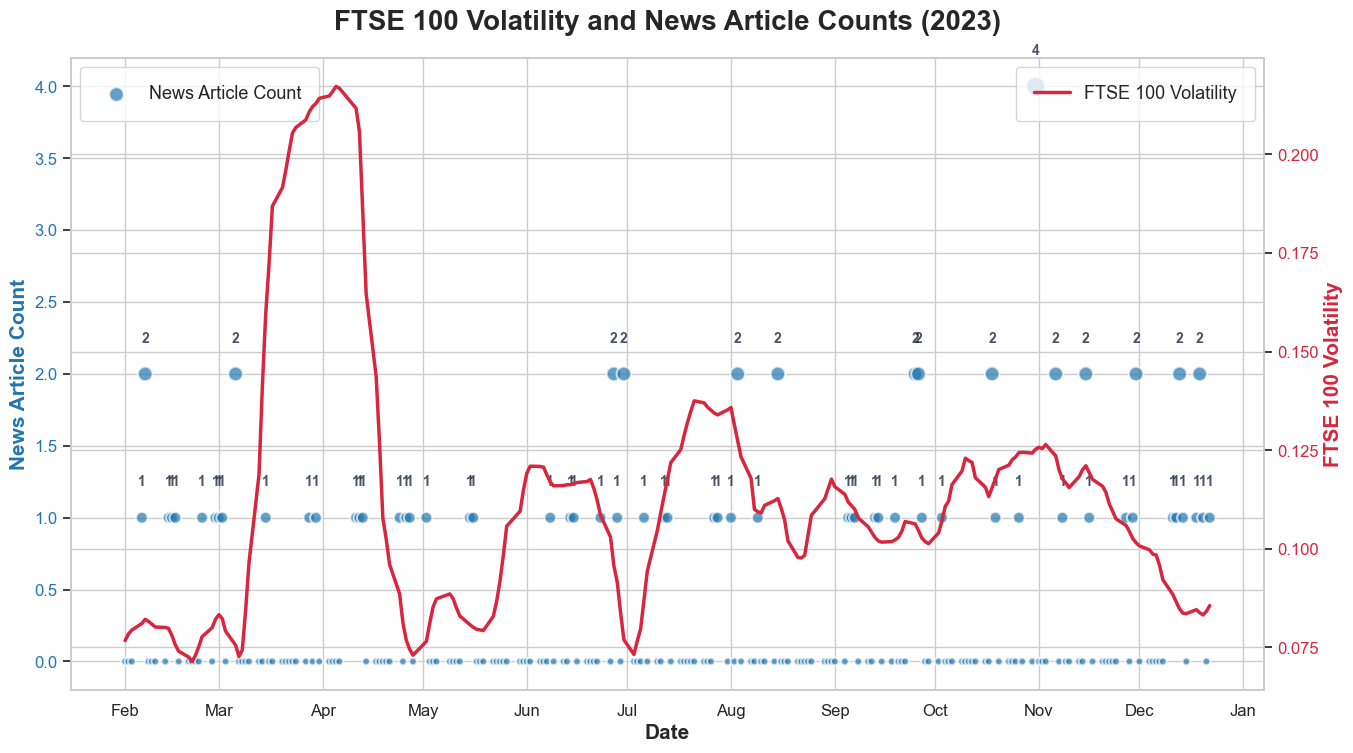

In [8]:
import seaborn as sns
sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 8))

# Volatility line (right y-axis)
ax2 = ax1.twinx()
sns.lineplot(x='date', y='Volatility_Smooth', data=merged, ax=ax2, color='#d7263d', label='FTSE 100 Volatility', linewidth=2.5, zorder=2)
ax2.set_ylabel("FTSE 100 Volatility", fontsize=15, color='#d7263d', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#d7263d', labelsize=12)
ax2.yaxis.set_major_locator(MaxNLocator(nbins=8))

# News article counts (left y-axis, as blue scatter)
ax1.scatter(merged['date'], merged['count'], s=merged['count']*40+30, color='#2176ae', alpha=0.7, edgecolor='white', linewidth=1.5, label='News Article Count', zorder=3)
ax1.set_ylabel("News Article Count", fontsize=15, color='#2176ae', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#2176ae', labelsize=12)
ax1.set_xlabel("Date", fontsize=15, fontweight='bold')

# Annotate article counts
for i, row in merged.iterrows():
    if row['count'] > 0:
        ax1.text(row['date'], row['count']+0.2, str(row['count']), color='#1b2a41', ha='center', va='bottom', fontsize=10, fontweight='bold', alpha=0.8)

# X-axis formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(DateFormatter('%b'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0, ha='center', fontsize=12)

# Title and legend
plt.title("FTSE 100 Volatility and News Article Counts (2023)", fontsize=20, fontweight='bold', pad=20)
ax1.legend(loc='upper left', fontsize=13, frameon=True, fancybox=True, borderpad=1)
ax2.legend(loc='upper right', fontsize=13, frameon=True, fancybox=True, borderpad=1)

plt.tight_layout(pad=2)
plt.show()

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")
model = AutoModelForSequenceClassification.from_pretrained("nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")

In [10]:
def infer_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = logits.softmax(dim=1)
    sentiment = probabilities.argmax(dim=1).item()
    return sentiment

# Add a column with the titles of each date
def get_titles(date):
    return news_df[news_df['date'].dt.date == date.date()]['title'].tolist()

In [11]:
# calculate sentiment for each date
def calculate_sentiment(date):
    titles = get_titles(date)
    if not titles:
        return None
    sentiments = [infer_sentiment(title) for title in titles]
    return sum(sentiments) / len(sentiments)

In [12]:
merged['sentiment'] = merged['date'].apply(calculate_sentiment)
merged['sentiment'] = merged['sentiment'].fillna(1) # Fill NaN values with -1 u

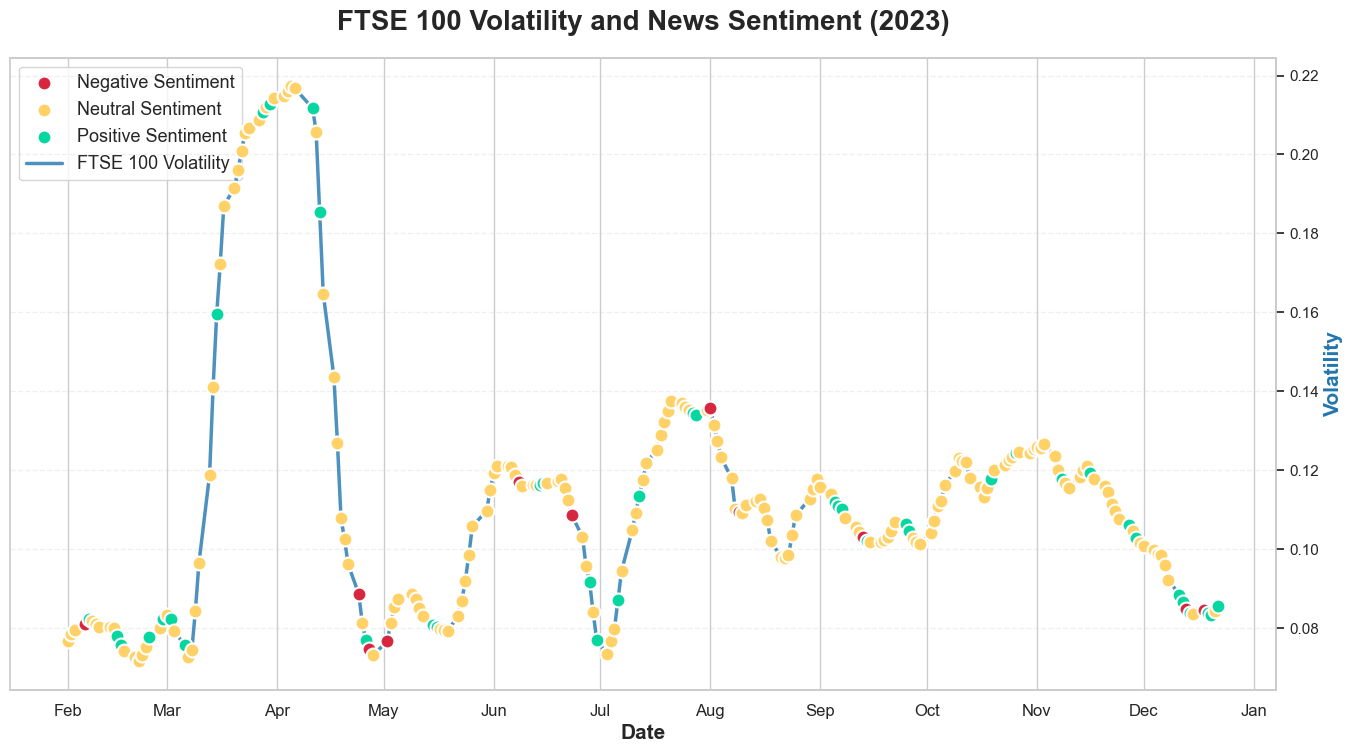

In [13]:
label_map = {"negative": 0, "neutral": 1, "positive": 2}
sentiment_colors = {0: "#d7263d", 1: "#ffd166", 2: "#06d6a0"}  # Red for negative, yellow for neutral, green for positive
inverse_label_map = {v: k for k, v in label_map.items()}

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()  # Create a second y-axis

# Plot volatility line
ax2.plot(merged['date'], merged['Volatility_Smooth'], color='#2176ae', linewidth=2.5, 
         label='FTSE 100 Volatility', alpha=0.8)

# Plot sentiment markers on the volatility line
for i, row in merged.iterrows():
    sentiment_value = int(row['sentiment'])
    # Plot sentiment markers directly on the volatility line
    ax2.scatter(row['date'], row['Volatility_Smooth'], 
               color=sentiment_colors[sentiment_value], 
               s=100, 
               zorder=5,
               edgecolor='white', 
               linewidth=1.5)

# Add colored marker samples for the legend
for sentiment_value in [0, 1, 2]:
    ax1.scatter([], [], color=sentiment_colors[sentiment_value], 
                label=f"{inverse_label_map[sentiment_value].capitalize()} Sentiment",
                s=100, edgecolor='white', linewidth=1.5)

# Format axes
ax1.set_xlabel("Date", fontsize=15, fontweight='bold')
ax2.set_ylabel("Volatility", fontsize=15, fontweight='bold', color='#2176ae')

# Hide the y-axis on the left since we're not using it for data
ax1.set_yticks([])
ax1.spines['left'].set_visible(False)

# Format date axis
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0, ha='center', fontsize=12)

# Add grid for better readability
ax2.grid(axis='y', linestyle='--', alpha=0.3)

# Add title
plt.title("FTSE 100 Volatility and News Sentiment (2023)", fontsize=20, fontweight='bold', pad=20)

# Create combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=13, frameon=True, fancybox=True)

plt.tight_layout(pad=2)
plt.show()
